#### 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

In [2]:
#pip install scikit-learn
#pip install seaborn

#### 2. Read file

In [3]:
df = pd.read_csv("reviews_processed_with_spacy_md.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354200 entries, 0 to 354199
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   firm               354200 non-null  object 
 1   date_review        354200 non-null  object 
 2   overall_rating     354200 non-null  int64  
 3   work_life_balance  354200 non-null  float64
 4   culture_values     354200 non-null  float64
 5   career_opp         354200 non-null  float64
 6   comp_benefits      354200 non-null  float64
 7   senior_mgmt        354200 non-null  float64
 8   recommend          354200 non-null  object 
 9   ceo_approv         354200 non-null  object 
 10  outlook            354200 non-null  object 
 11  headline           352907 non-null  object 
 12  pros               354200 non-null  object 
 13  cons               354197 non-null  object 
 14  status             354200 non-null  object 
 15  experience         354200 non-null  object 
 16  he

In [4]:
df.head()

,firm,date_review,overall_rating,work_life_balance,culture_values,career_opp,comp_benefits,senior_mgmt,recommend,ceo_approv,outlook,headline,pros,cons,status,experience,headline_clean,pros_clean,cons_clean,full_text_clean
0,Apple,2008-01-31,5,3.0,5.0,3.0,4.0,4.0,v,v,o,We make products that poeple enjoy buying and ...,The people we work with are great and I can't ...,You have to be careful because this job can ta...,current,No information,product poeple enjoy buy,people work great not imagine life will produc...,careful job life careful need learn seperate ...,product poeple enjoy buy. people work great no...
1,Apple,2008-02-14,4,4.0,5.0,3.0,4.0,3.0,v,v,o,It is a different job because of all of the di...,The big positive for me is that I really do en...,I suppose that a con would be that there is a ...,current,No information,different job different creative product work,big positive enjoy job apple innovative change...,suppose con hard balance work home life,different job different creative product work....
2,Apple,2008-02-15,5,4.0,5.0,5.0,5.0,5.0,v,v,o,Working at Apple is the hardest job you will e...,When you work at a place like Apple you have a...,The people at Apple are living on the bleeding...,current,No information,work apple hard job love,work place like apple opportunity change way w...,people apple live bleed edge not know future h...,work apple hard job love. work place like appl...
3,Apple,2008-04-20,5,5.0,5.0,5.0,4.0,5.0,v,v,o,"A retail job that is altogether exciting, thri...",Despite the fact that it all boils down to sel...,"As part of their intensive training, there are...",current,No information,retail job altogether exciting thrilling life ...,despite fact boil sell product apple make feel...,intensive training mandatory meeting month pos...,retail job altogether exciting thrilling life ...
4,Apple,2008-04-20,2,3.0,5.0,2.0,3.0,1.0,x,x,o,Worst choice ever.,The benefits for fulltime employees were great...,Too much confidentiality. You couldn't even f...,former,No information,bad choice,benefit fulltime employee great stock option r...,confidentiality not fart get reprimand way fee...,bad choice. benefit fulltime employee great st...


#####  3. Create target variable 'sentiment'

In [5]:
# Remove neutral rating
df = df[df['overall_rating'] != 3].copy()

# Combine texts
df['text'] = df['headline_clean'].fillna('') + ' ' + df['pros_clean'].fillna('') + ' ' + df['cons_clean'].fillna('')

# Classification by the rating (binary rating positive/negative)
df['sentiment'] = df['overall_rating'].apply(lambda x: 'positive' if x > 3 else 'negative')

# Create encoded labels
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})

In [6]:
# Verify the targets and labels
df[['overall_rating', 'sentiment', 'label']].head()

,overall_rating,sentiment,label
0,5,positive,1
1,4,positive,1
2,5,positive,1
3,5,positive,1
4,2,negative,0


In [7]:
# save dataset version containing target and labels
df.to_csv('clean_reviews_with_labels.csv', index=False)

##### 4. Verify the balance of 2 categories

In [8]:
df['sentiment'].value_counts(normalize=True)

sentiment
positive    0.810786
negative    0.189214
Name: proportion, dtype: float64

L’échantillon est légèrement déséquilibré (81 % d’avis positifs / 19 % négatifs).

Le score F1 va être utilisé comme métrique principale, et pas uniquement la précision, pour éviter qu’un modèle semble performant simplement en prédisant toujours la classe majoritaire (positive).

##### 5. Split dataset to train and test

In [9]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

#### 6. Tester modèle baseline TF-IDF + Régression logistique sur des textes pré-traités

##### TF-IDF vectorization

In [10]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')  # it's possible to add ngram_range=(1,2)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

Train logistic regression

In [11]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

Asessment of the model results

In [12]:
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.55      0.65     12483
           1       0.90      0.97      0.93     53492

    accuracy                           0.89     65975
   macro avg       0.85      0.76      0.79     65975
weighted avg       0.88      0.89      0.88     65975

[[ 6922  5561]
 [ 1757 51735]]


Interpretation des résultats:
Le modèle est très performant pour détecter les positifs.
Mais il a des difficultés à détecter correctement les négatifs, avec un rappel de 55% seulement.

Classe “negative” : F1-score = 0.65 :
Moyenne harmonique entre précision et rappel : équilibre moyen.

Classe “positive” : F1-score = 0.93 :
Très bon équilibre pour cette classe.


Ce déséquilibre pourrait être dû à un dataset déséquilibré ou à une classe “negative” moins bien représentée ou plus ambiguë.


In [13]:
# Create confusion matrix
labels = [0, 1]
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Normalize by line to get percents
cm_perc = cm / cm.sum(axis=1, keepdims=True)

# Create annotations in percents
annotations = np.array([[f"{v:.1%}" for v in row] for row in cm_perc])

# Création de la heatmap avec annotations
fig = go.Figure(data=go.Heatmap(
    z=cm_perc,
    x=labels,
    y=labels,
    colorscale='Blues',
    colorbar=dict(title="Taux")
))

# Ajouter les annotations (texte au centre des cases)
for i in range(len(labels)):
    for j in range(len(labels)):
        fig.add_annotation(dict(
            x=labels[j],
            y=labels[i],
            text=annotations[i, j],
            showarrow=False,
            font=dict(color="black", size=16)
        ))

fig.update_layout(
    title='Matrice de confusion - Classification des sentiments',
    xaxis_title='Prévu',
    yaxis_title='Réel',
    yaxis_autorange='reversed',  # Pour que la matrice s’affiche dans l’ordre attendu
    width=500,   # fixed width
    height=500,  # fixed length
    margin=dict(l=60, r=60, t=60, b=60)
)

# fixed axis ratio
fig.update_yaxes(scaleanchor="x", scaleratio=1)


fig.show()

              
##### Real Negative -	                     55.5% (True Neg)	   /   44.5% (False Pos)
##### Real Positive - 	                     3.3% (False Neg)	   /   96.7% (True Pos)

### 7. Tester le modèle après l'apport d'une amélioration  - limiter ou ajuster le vocabulaire TF-IDF

Exemple: TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8)

- max_features : limite le nombre total de mots considérés → plus rapide, moins de bruit ;

- min_df : ignore les mots trop rares ;

- max_df : ignore les mots trop fréquents (souvent non-informatifs).

In [14]:
# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.8, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

#Show model results
y_pred = model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.56      0.66     12483
           1       0.90      0.97      0.93     53492

    accuracy                           0.89     65975
   macro avg       0.85      0.76      0.80     65975
weighted avg       0.88      0.89      0.88     65975

[[ 6937  5546]
 [ 1723 51769]]


In [15]:
# Create confusion matrix
labels = [0,1]
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Visualization
# Normalize by line to get percents
cm_perc = cm / cm.sum(axis=1, keepdims=True)

# Create annotations in percents
annotations = np.array([[f"{v:.1%}" for v in row] for row in cm_perc])

# Création de la heatmap avec annotations
fig = go.Figure(data=go.Heatmap(
    z=cm_perc,
    x=labels,
    y=labels,
    colorscale='Blues',
    colorbar=dict(title="Taux")
))

# Ajouter les annotations (texte au centre des cases)
for i in range(len(labels)):
    for j in range(len(labels)):
        fig.add_annotation(dict(
            x=labels[j],
            y=labels[i],
            text=annotations[i, j],
            showarrow=False,
            font=dict(color="black", size=16)
        ))

fig.update_layout(
    title='Matrice de confusion - Classification des sentiments',
    xaxis_title='Prévu',
    yaxis_title='Réel',
    yaxis_autorange='reversed',  # Pour que la matrice s’affiche dans l’ordre attendu
      width=500,   # fixed width
    height=500,  # fixed length
    margin=dict(l=60, r=60, t=60, b=60)
)

# fixed axis ratio
fig.update_yaxes(scaleanchor="x", scaleratio=1)


fig.show()

#### Les ajustements sur TfidfVectorizer n'ont eu qu’un impact minime, voire négligeable.

Possibles raisons:

- TF-IDF a déjà des limites : il ne capture pas le sens, la structure grammaticale ni la sémantique profonde.
- Les classes sont déséquilibrées, le modèle reste biaisé vers le positif.
- Tes textes sont déjà bien prétraités  -  pas beaucoup à gagner avec l'ajustement du vocabulaire TF-IDF (paramètres min_df, max_df ou max_features)



### 8. Tenter une GridSearchCV (tester différentes valeurs de C (régularisation) dans LogisticRegression)

In [16]:
from sklearn.model_selection import GridSearchCV

# Determine the list of values of the hyperparameters to be tested
params = {'C': [0.01, 0.1, 1, 10]}

# GridSearch with Logistic Regression
grid = GridSearchCV(
    LogisticRegression(max_iter=1000),
    params,
    scoring='f1_macro',
    cv=5
)
grid.fit(X_train_tfidf, y_train)

# Best model and result
print("Best params:", grid.best_params_)
print("Best f1_macro score:", grid.best_score_)

Best params: {'C': 10}
Best f1_macro score: 0.7962719751356849


Tester le meilleur modèle

In [17]:
# Chose the model with the best param
best_model = grid.best_estimator_

# Save the best model
#import joblib
#joblib.dump(best_model, 'best_model.pkl')

# Save vectorizer
#joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

#Show model results
y_pred = best_model.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.57      0.66     12483
           1       0.91      0.96      0.93     53492

    accuracy                           0.89     65975
   macro avg       0.84      0.77      0.80     65975
weighted avg       0.88      0.89      0.88     65975

[[ 7176  5307]
 [ 1985 51507]]


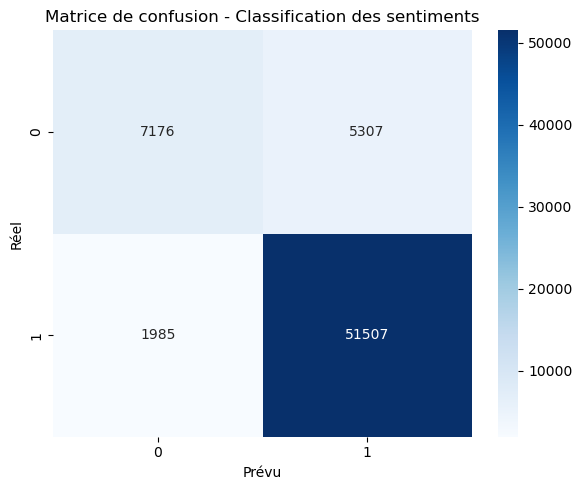

In [18]:
# Create confusion matrix
labels = [0,1]
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Visualization
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Prévu')   # Predicted
plt.ylabel('Réel')    # Actual
plt.title('Matrice de confusion - Classification des sentiments')
plt.tight_layout()
plt.show()

Matrice avec des poucentages

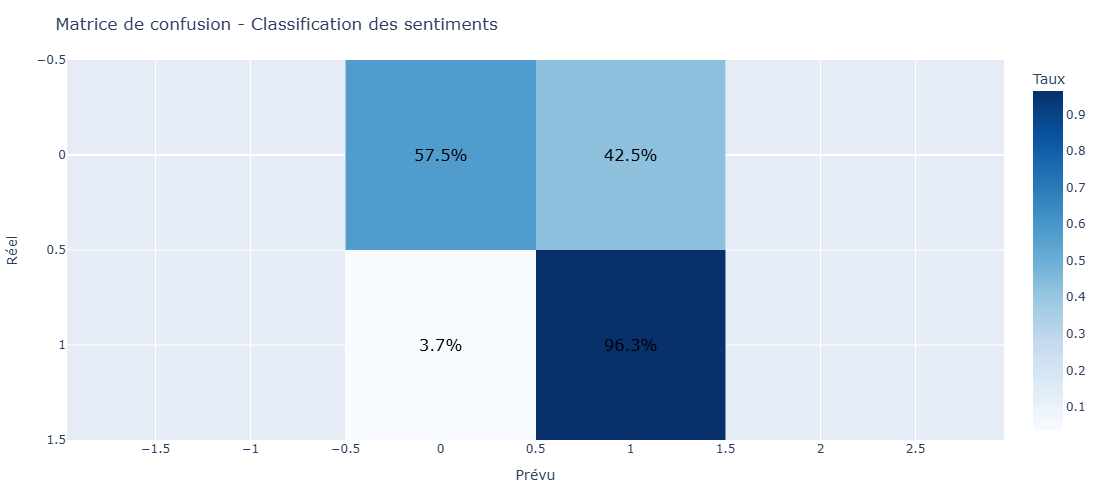

In [19]:
# Create confusion matrix
labels = [0,1]
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Visualization
# Normalize by line to get percents
cm_perc = cm / cm.sum(axis=1, keepdims=True)

# Create annotations in percents
annotations = np.array([[f"{v:.1%}" for v in row] for row in cm_perc])

# Création de la heatmap avec annotations
fig = go.Figure(data=go.Heatmap(
    z=cm_perc,
    x=labels,
    y=labels,
    colorscale='Blues',
    colorbar=dict(title="Taux")
))

# Ajouter les annotations (texte au centre des cases)
for i in range(len(labels)):
    for j in range(len(labels)):
        fig.add_annotation(dict(
            x=labels[j],
            y=labels[i],
            text=annotations[i, j],
            showarrow=False,
            font=dict(color="black", size=16)
        ))

fig.update_layout(
    title='Matrice de confusion - Classification des sentiments',
    xaxis_title='Prévu',
    yaxis_title='Réel',
    yaxis_autorange='reversed',  # Pour que la matrice s’affiche dans l’ordre attendu
    width=500,   # fixed width
    height=500,  # fixed length
    margin=dict(l=60, r=60, t=60, b=60)
)

# fixed axis ratio
fig.update_yaxes(scaleanchor="x", scaleratio=1)


fig.show()

#### On a obtenu des résultats quasiment identiques avec GridSearch

Possibles raisons:
- Même avec un C optimal, le modèle reste biaisé vers la classe majoritaire
- Pas de traitement du déséquilibre dans le GridSearch
- On peut tester GridSearch après SMOTE pour voir une réelle différence

#### 9 Tester GridSearch après rééchantillonnage (SMOTE) (OPTIONNEL)

Application de SMOTE (en partant de la TF-IDF existante)

In [20]:
#!pip install imbalanced-learn

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import TruncatedSVD

# reduce dimensionality to 200 components
svd = TruncatedSVD(n_components=200, random_state=42)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_test_reduced = svd.transform(X_test_tfidf)

# Apply SMOTE on the vertorized data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_reduced, y_train)

In [23]:
# Train GridSearchCV on resampled data
params = {'C': [0.01, 0.1, 1, 10]}
grid_smote = GridSearchCV(
    LogisticRegression(max_iter=1000),
    params,
    scoring='f1_macro',
    cv=5
)
grid_smote.fit(X_train_resampled, y_train_resampled)

print("Best params:", grid_smote.best_params_)
print("Best f1_macro score (cross-validation):", grid_smote.best_score_)

# Prediction
y_pred = grid_smote.best_estimator_.predict(X_test_reduced)

# Estimation of performance
print("Rapport de classification :")
print(classification_report(y_test, y_pred))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))

Best params: {'C': 1}
Best f1_macro score (cross-validation): 0.8175078959390429
Rapport de classification :
              precision    recall  f1-score   support

           0       0.47      0.76      0.58     12483
           1       0.93      0.80      0.86     53492

    accuracy                           0.79     65975
   macro avg       0.70      0.78      0.72     65975
weighted avg       0.85      0.79      0.81     65975

Matrice de confusion :
[[ 9487  2996]
 [10697 42795]]


Méthode testée pour compenser le léger déséquilibre entre les classes positive et negative - SMOTE (Synthetic Minority Oversampling Technique)

**Resultat**: cela n’a permis d’améliorer les performances. Au contraire, les scores de validation (précision, rappel, F1) ont été **légèrement inférieurs** à ceux du modèle de base, sans ajustement.

**Possible raisons:**
- Le déséquilibre n’était pas si problématique: parfois, les modèles (comme la régression logistique) sont capables de gérer un léger déséquilibre mieux qu’une surcorrection.

- SMOTE peut parfois empirer les choses: les exemples synthétiques peuvent ne plus correspondre à de vrais textes (perte de structure sémantique, introduction de bruit)

**Conclusion**: le modèle avec les meilleurs résultats a été entraîné sans pondération ni suréchantillonnage.

#### La suite logique serait donc de tester une méthode plus riche en représentation comme les embeddings de mots (Word2Vec par ex) ou les Transformers (BERT), pour voir si cela permet au modèle de mieux capturer la nuance des sentiments dans les textes.